<h2>Problem Statement:</h2>

Through the analysis and modeling of the Aimes, Iowa dataset of 2006 - 2010 home sales, can a best mix of features be constructed to predict the sale price of homes in a given market? 

<h1>Exploratory Data Analysis & Cleaning<h1>

<h2>Import Packages<h2>

In [1]:
#basic DS packages

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#for all models
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, PowerTransformer
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm

#for regression models
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV


#for Jupyter notebook:
%matplotlib inline

<h2>Import Data into DataFrame<h2>

In [2]:
df = pd.read_csv('./datasets/train.csv')
outside_df = pd.read_csv('./datasets/test.csv')

In [3]:
#Remove the max column setting in pandas

pd.options.display.max_columns = None
pd.options.display.max_rows = None

<h2>Explore the Data</h2>

<h4>How many rows and columns are we dealing with?</h4>

In [4]:
#2051 rows and 81 columns of data

df.shape

(2051, 81)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
Id                 2051 non-null int64
PID                2051 non-null int64
MS SubClass        2051 non-null int64
MS Zoning          2051 non-null object
Lot Frontage       1721 non-null float64
Lot Area           2051 non-null int64
Street             2051 non-null object
Alley              140 non-null object
Lot Shape          2051 non-null object
Land Contour       2051 non-null object
Utilities          2051 non-null object
Lot Config         2051 non-null object
Land Slope         2051 non-null object
Neighborhood       2051 non-null object
Condition 1        2051 non-null object
Condition 2        2051 non-null object
Bldg Type          2051 non-null object
House Style        2051 non-null object
Overall Qual       2051 non-null int64
Overall Cond       2051 non-null int64
Year Built         2051 non-null int64
Year Remod/Add     2051 non-null int64
Roof Style         20

<h2>Dealing with NaN's</h2>

<h3>Consult the Data Dictionary

<h4>Determine NaN's for Categorical Data and Replace/Drop</h4>

In [6]:
#Calculate null quantities for all categorical columns, and replace NaN with none.
#I have manually checked the data dictionary to confirm that this is an adequate solution.

null_cat_columns = []  #Saves list of the NaN category columns that have been filled with 'None'. Only for reference.  

for i in df:
    if (df[i].isnull().sum() > 0) & (df[i].dtype == 'O'):
        null_cat_columns.append(i)
        df[i].fillna('None', inplace = True)


<h4>Determine NaN's for Non-Categorical Data and Replace/Drop</h4>

In [7]:
#List null quantities for non-categorical quantities.
#These lists are useful because there are SO many columns, that many get cut off when checking manually with .isnull()

for i in df:
    if (df[i].isnull().sum() > 0):
        print(f'{i}: \nTotal: {df[i].isnull().sum()}\nPct: {df[i].isnull().mean()}\n')

Lot Frontage: 
Total: 330
Pct: 0.16089712335446124

Mas Vnr Area: 
Total: 22
Pct: 0.010726474890297415

BsmtFin SF 1: 
Total: 1
Pct: 0.00048756704046806434

BsmtFin SF 2: 
Total: 1
Pct: 0.00048756704046806434

Bsmt Unf SF: 
Total: 1
Pct: 0.00048756704046806434

Total Bsmt SF: 
Total: 1
Pct: 0.00048756704046806434

Bsmt Full Bath: 
Total: 2
Pct: 0.0009751340809361287

Bsmt Half Bath: 
Total: 2
Pct: 0.0009751340809361287

Garage Yr Blt: 
Total: 114
Pct: 0.05558264261335934

Garage Cars: 
Total: 1
Pct: 0.00048756704046806434

Garage Area: 
Total: 1
Pct: 0.00048756704046806434



In [8]:
df['Lot Frontage'].describe()

count    1721.000000
mean       69.055200
std        23.260653
min        21.000000
25%        58.000000
50%        68.000000
75%        80.000000
max       313.000000
Name: Lot Frontage, dtype: float64

In [9]:
#Replace NaN's with 0 for Masonry Veneer Type, Basement Half Bath, and Basement Full Bath

df['Lot Frontage'].fillna(61, inplace = True) # 10 is an arbitrary lowest number.  It seems as if 21 might be the default min, so avoided using 0.  
df['Mas Vnr Area'].fillna(0, inplace = True)
df['Bsmt Half Bath'].fillna(0, inplace = True)
df['Bsmt Full Bath'].fillna(0, inplace = True)

In [10]:
outside_df['Lot Frontage'].fillna(61, inplace = True) #10 is an arbitrary lowest number.  It seems as if 21 might be the default min, so avoided using 0.  
outside_df['Mas Vnr Area'].fillna(0, inplace = True)




<h4>Drop Unecessary Columns with too many NaN's to Manually Resolve</h4>

In [11]:
#Columns to drop

drop_columns = ['Garage Yr Blt']

In [12]:
df.drop(drop_columns, axis = 1, inplace = True)

<h4>Manually isolate and replace remmaining NaN's</h4>

In [13]:
#Only row with NaN in specific basement columns

df.iloc[1327] = df.iloc[1327].fillna(0)

In [14]:
#Only row with NaN in specific garage columns

df.iloc[1712] = df.iloc[1712].fillna(0)

In [15]:
df.isnull().sum().sum()

0

<h2>Data Type Adjustment</h2>

<u><b>Note:</b></u>  Any categorical changes should be processed on both datasets simultaneously

<h4>Categorize Month & Year Sold (and Dummy)</h4>

In [16]:
#Create dummy df's for month and year, to be concatenated with the full df, but also available for later analysis.

#For inside dataframe

mo_sold_dummy = pd.get_dummies(df['Mo Sold'], drop_first = True)
yr_sold_dummy = pd.get_dummies(df['Yr Sold'], drop_first = True)
mo_and_year_dummy = pd.concat([mo_sold_dummy, yr_sold_dummy], axis = 1)

# #For outside dataframe

mo_sold_dummy_out = pd.get_dummies(outside_df['Mo Sold'], drop_first = True)
yr_sold_dummy_out = pd.get_dummies(outside_df['Yr Sold'], drop_first = True)
mo_and_year_outside_dummy = pd.concat([mo_sold_dummy_out, yr_sold_dummy_out], axis = 1)

<h4>Create Polynomial Calendar Features</h4>

In [17]:
#instantiate a Polynomial Features variable.

poly = PolynomialFeatures(include_bias = False)

In [18]:
#Create a polynomial feature database of month and year combinations.  Irrational ones (i.e. Feb * Mar) to be dropped.

#inside dataframe

mo_yr_poly = poly.fit_transform(mo_and_year_dummy)
mo_yr_poly_df = pd.DataFrame(mo_yr_poly, columns = poly.get_feature_names(mo_and_year_dummy.columns.astype(str)))


# #outside dataframe

mo_yr_poly_out = poly.fit_transform(mo_and_year_outside_dummy)
mo_yr_poly_outside_df = pd.DataFrame(mo_yr_poly_out, columns = poly.get_feature_names(mo_and_year_outside_dummy.columns.astype(str)))







In [19]:
#mo_yr_poly_outside_df.describe()

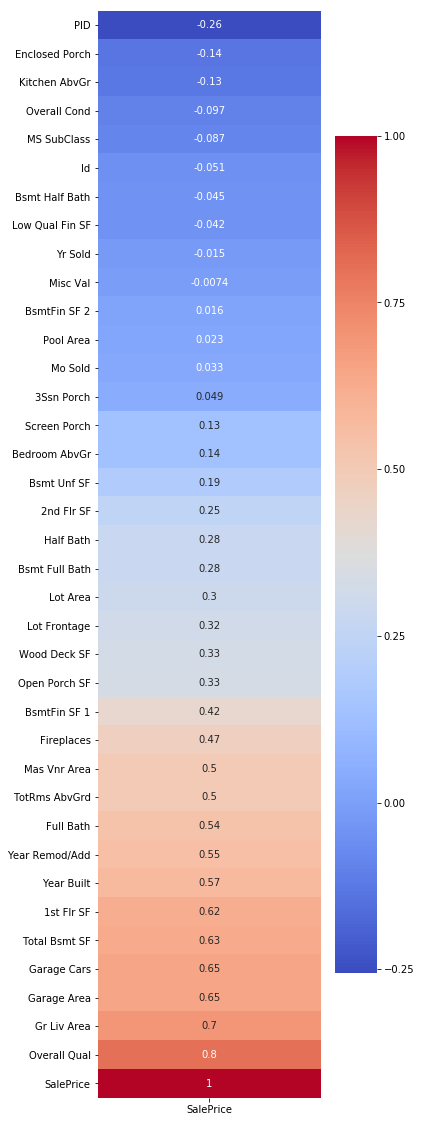

In [20]:
plt.figure(figsize = (5,20))

sns.heatmap(df.corr()[['SalePrice']].sort_values('SalePrice'), annot = True, cmap = 'coolwarm')

In [21]:
#Manually Created Polynomial Features influenced by above correlations.

df['Qual2'] = df['Overall Qual']**2
df['BasmtSF_Qual'] = df['Total Bsmt SF'] * df['Overall Qual']
df['YearBuilt_Qual'] = df['Year Built'] * df['Overall Qual']
df['GarageArea_Qual'] = df['Garage Area'] * df['Overall Qual']
df['LivArea_Qual'] = df['Gr Liv Area'] * df['Overall Qual']
df['LivArea_GarageArea_Qual'] = df['LivArea_Qual'] * df['Garage Area']



#Apply the above manual features to the outside data set.

outside_df['Qual2'] = outside_df['Overall Qual']**2
outside_df['BasmtSF_Qual'] = outside_df['Total Bsmt SF'] * outside_df['Overall Qual']
outside_df['YearBuilt_Qual'] = outside_df['Year Built'] * outside_df['Overall Qual']
outside_df['GarageArea_Qual'] = outside_df['Garage Area'] * outside_df['Overall Qual']
outside_df['LivArea_Qual'] = outside_df['Gr Liv Area'] * outside_df['Overall Qual']
outside_df['LivArea_GarageArea_Qual'] = outside_df['LivArea_Qual'] * outside_df['Garage Area']


In [22]:
# Manually created list of categorical variables to be dummied.  

list_to_dummy = ['Neighborhood','Sale Type','MS SubClass', 'MS Zoning', 'Street', 'Alley','Lot Shape', 'Land Contour',
                 'Utilities', 'Lot Config', 'Land Slope','Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 
                 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
                 'Exter Qual','Exter Cond','Foundation','Bsmt Qual','Bsmt Cond','Bsmt Exposure','BsmtFin Type 1',
                 'BsmtFin Type 2','Heating','Heating QC','Central Air','Electrical','Kitchen Qual','Functional',
                 'Fireplace Qu','Garage Type','Garage Finish','Garage Qual','Garage Cond','Paved Drive','Pool QC',
                 'Fence','Misc Feature']


In [23]:
df.shape

(2051, 86)

In [24]:
df.head(1)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,Qual2,BasmtSF_Qual,YearBuilt_Qual,GarageArea_Qual,LivArea_Qual,LivArea_GarageArea_Qual
0,109,533352170,60,RL,61.0,13517,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,None,Attchd,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,None,None,None,0,3,2010,WD,130500,36,4350.0,11856,2850.0,8874,4215150.0


In [25]:
outside_df.shape

(879, 86)

In [26]:
#Create and add dummy columns from the above dummy list to 'df'

df = pd.get_dummies(df, columns=list_to_dummy, drop_first = True)

In [27]:
df.shape

(2051, 283)

In [28]:
#Create and add dummy columns from the above dummy list to 'outside_df'

outside_df = pd.get_dummies(outside_df, columns=list_to_dummy, drop_first = True)

In [29]:
outside_df.shape

(879, 250)

In [30]:
#Merge dataframe ('df') with calendar dataframes

df = pd.concat([df, mo_yr_poly_df], axis = 1)
outside_df = pd.concat([outside_df, mo_yr_poly_outside_df], axis = 1)

In [31]:
#print shape of calendar polynomial features

print(mo_yr_poly_df.shape)
print(mo_yr_poly_outside_df.shape)

(2051, 135)
(879, 135)


In [32]:
#Additional Manually Created Polynomial Features influenced by above correlations.

df['TA_cond'] = df['Exter Qual_TA'] * df['Overall Cond']
df['TA_combo'] = df['Exter Qual_TA'] * df['Kitchen Qual_TA']
df['TA_KitchBsmt'] = df['Kitchen Qual_TA'] * df['Bsmt Qual_TA']
df['QualCond_LivArea'] = df['LivArea_Qual'] * df['Overall Cond']
df['LivArea_Cond'] = df['Gr Liv Area'] * df['Overall Cond']
df['YearBuilt_Qual'] = df['Overall Qual'] * df['Year Built']
df['YearRemod_Qual'] = df['Overall Qual'] * df['Year Remod/Add']

outside_df['TA_cond'] = outside_df['Exter Qual_TA'] * outside_df['Overall Cond']
outside_df['TA_combo'] = outside_df['Exter Qual_TA'] * outside_df['Kitchen Qual_TA']
outside_df['TA_KitchBsmt'] = outside_df['Kitchen Qual_TA'] * outside_df['Bsmt Qual_TA']
outside_df['QualCond_LivArea'] = outside_df['LivArea_Qual'] * outside_df['Overall Cond']
outside_df['LivArea_Cond'] = outside_df['Gr Liv Area'] * outside_df['Overall Cond']
outside_df['YearBuilt_Qual'] = outside_df['Overall Qual'] * outside_df['Year Built']
outside_df['YearRemod_Qual'] = outside_df['Overall Qual'] * outside_df['Year Remod/Add']

In [33]:
#print df and outside df features

print(df.shape)
print(outside_df.shape)

(2051, 424)
(879, 391)


<h3>Declare target column</h3>

In [34]:
#Pull out 'SalePrice' before trimming dummy columns from dataframes
y = df['SalePrice']

<h3>Drop Columns with Zero Data in Either Dataframe</h3>

In [35]:
#Drop all dummy columns in df that doesn't have any values.  No value add if there is no data in the training df.

for col in df:
    if (df[col].min() == False) & (df[col].max() == False):
        df.drop(col, axis = 1, inplace = True)

In [36]:
df.shape

(2051, 358)

In [37]:
#Drop columns that are only in the main 'df'

for col in outside_df:
    if col not in df:
        outside_df.drop([col], axis = 1, inplace = True)

In [38]:
#Drop columns only in the 'outside' dataframe.

for col in df:
    if col not in outside_df:
        df.drop([col], axis = 1, inplace = True)

In [39]:
#Confirm shape of df
df.shape

(2051, 315)

In [40]:
#COnfirm the shape of outside df

outside_df.shape

(879, 315)

<h2>Feature Selection</h2>

In [41]:
#Prepare the data to model

features = [col for col in df._get_numeric_data().columns]  #Thank Riley for this gem
X = df[features].drop(columns = ['Id', 'PID'])  #matrix
y = y  #vector


In [42]:
#Prepare the outside data set

outside_features = [col for col in outside_df._get_numeric_data().columns]
outside_X = outside_df[outside_features].drop(columns = ['Id', 'PID'])  #matrix

In [135]:
X.shape

(2039, 176)

In [136]:
outside_X.shape

(879, 176)

<h3>Below 2 Cells for Intermediate Correlation Visualization ONLY</h4>

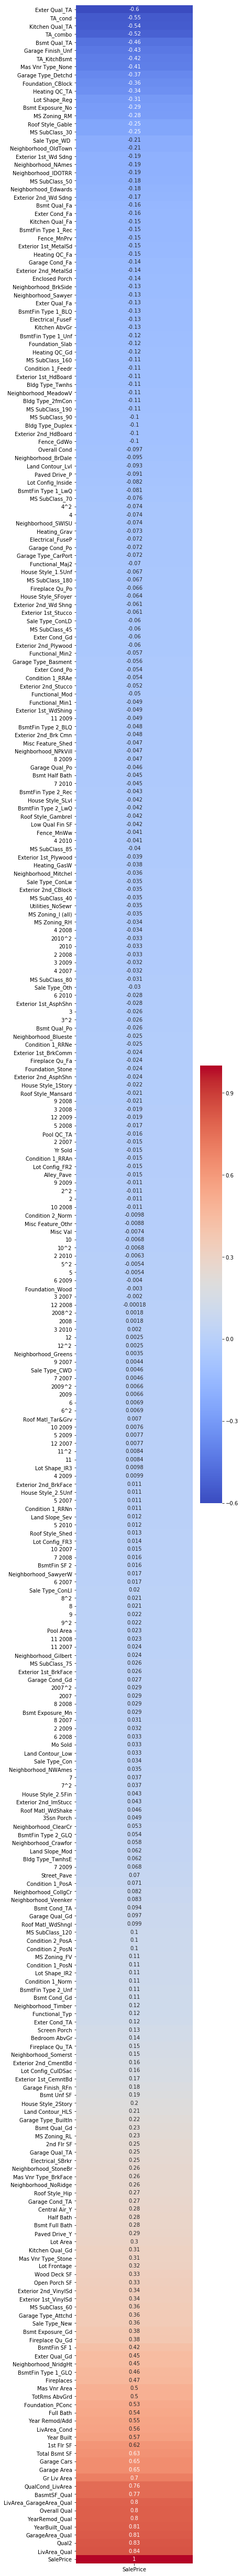

In [45]:
#Re-Explore correlations with 'SalePrice' before setting up model

X['SalePrice'] = y

plt.figure(figsize = (5,90))



sns.heatmap(X.corr()[['SalePrice']].sort_values('SalePrice'), annot = True, cmap = 'coolwarm')


X.drop('SalePrice', axis = 1, inplace = True)

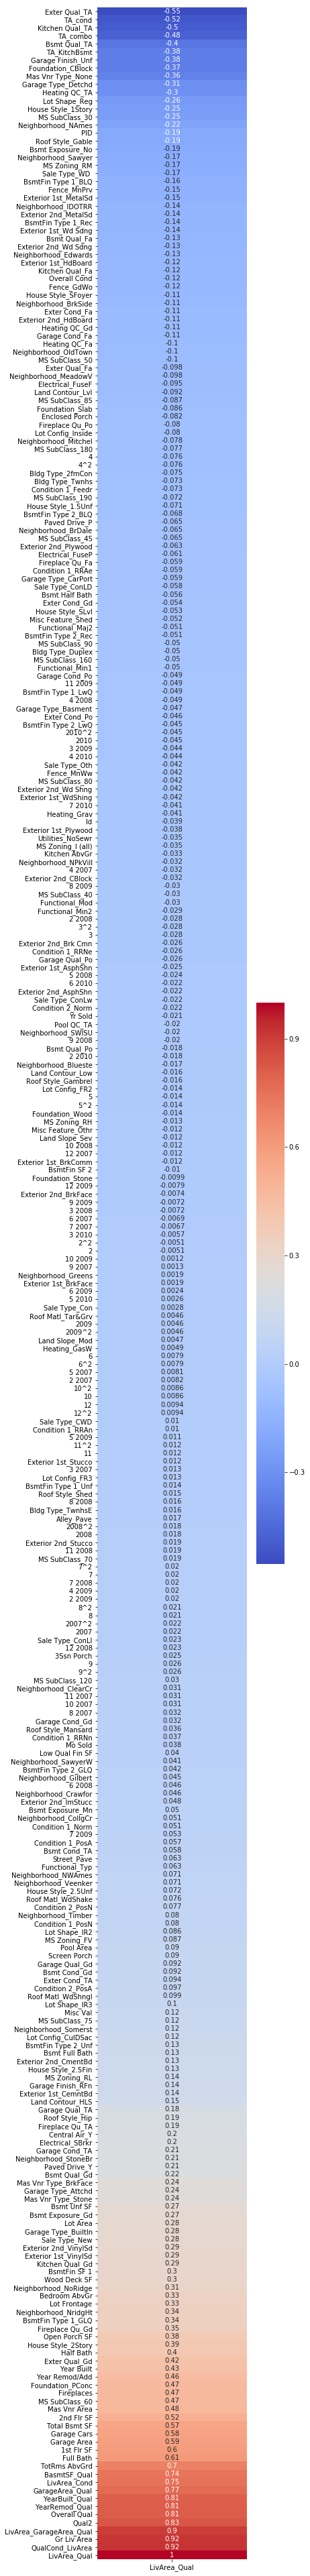

In [47]:
#Compare to above

plt.figure(figsize = (5,70))

sns.heatmap(df.corr()[['LivArea_Qual']].sort_values('LivArea_Qual'), annot = True, cmap = 'coolwarm')

<h2>Instantiate and Build Model</h2>

In [185]:
#Instantiate the model on the Linear Regression class 

model = LinearRegression()

In [186]:
model.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [187]:
# After fitting our model, we can generate predictions.
y_pred = model.predict(X)

In [188]:
#The default score on regression model in sklearn is R^2.  Below is the R^2 of the model

model.score(X, y)

0.9587425265236661

In [189]:
rmse = np.sqrt(mean_squared_error(y, y_pred))
rmse

15529.638702818569

In [190]:
#The model's coefficients

coef = model.coef_
yint = model.intercept_

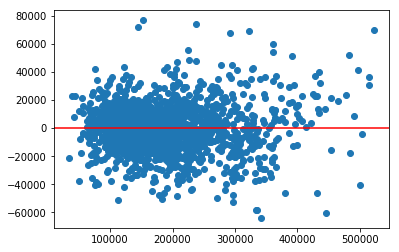

In [191]:
#Calculate the residuals and find their mean

residuals = y - y_pred
residuals.mean()

plt.scatter(x = y_pred, y = residuals)
plt.axhline(0, color='r')


In [192]:
df['residuals'] = residuals

In [194]:
df.sort_values('residuals', ascending = False).head(20)

,Id,PID,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Qual2,BasmtSF_Qual,YearBuilt_Qual,GarageArea_Qual,LivArea_Qual,LivArea_GarageArea_Qual,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD,MS SubClass_30,MS SubClass_40,MS SubClass_45,MS SubClass_50,MS SubClass_60,MS SubClass_70,MS SubClass_75,MS SubClass_80,MS SubClass_85,MS SubClass_90,MS SubClass_120,MS SubClass_160,MS SubClass_180,MS SubClass_190,MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Street_Pave,Alley_Pave,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Utilities_NoSewr,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Land Slope_Mod,Land Slope_Sev,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Norm,Condition 2_PosA,Condition 2_PosN,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,House Style_1.5Unf,House Style_1Story,House Style_2.5Fin,House Style_2.5Unf,House Style_2Story,House Style_SFoyer,House Style_SLvl,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,Roof Style_Shed,Roof Matl_Tar&Grv,Roof Matl_WdShake,Roof Matl_WdShngl,Exterior 1st_AsphShn,Exterior 1st_BrkComm,Exterior 1st_BrkFace,Exterior 1st_CemntBd,Exterior 1st_HdBoard,Exterior 1st_MetalSd,Exterior 1st_Plywood,Exterior 1st_Stucco,Exterior 1st_VinylSd,Exterior 1st_Wd Sdng,Exterior 1st_WdShing,Exterior 2nd_AsphShn,Exterior 2nd_Brk Cmn,Exterior 2nd_BrkFace,Exterior 2nd_CBlock,Exterior 2nd_CmentBd,Exterior 2nd_HdBoard,Exterior 2nd_ImStucc,Exterior 2nd_MetalSd,Exterior 2nd_Plywood,Exterior 2nd_Stucco,Exterior 2nd_VinylSd,Exterior 2nd_Wd Sdng,Exterior 2nd_Wd Shng,Mas Vnr Type_BrkFace,Mas Vnr Type_None,Mas Vnr Type_Stone,Exter Qual_Fa,Exter Qual_Gd,Exter Qual_TA,Exter Cond_Fa,Exter Cond_Gd,Exter Cond_Po,Exter Cond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Bsmt Qual_Fa,Bsmt Qual_Gd,Bsmt Qual_Po,Bsmt Qual_TA,Bsmt Cond_Gd,Bsmt Cond_TA,Bsmt Exposure_Gd,Bsmt Exposure_Mn,Bsmt Exposure_No,BsmtFin Type 1_BLQ,BsmtFin Type 1_GLQ,BsmtFin Type 1_LwQ,BsmtFin Type 1_Rec,BsmtFin Type 1_Unf,BsmtFin Type 2_BLQ,BsmtFin Type 2_GLQ,BsmtFin Type 2_LwQ,BsmtFin Type 2_Rec,BsmtFin Type 2_Unf,Heating_GasW,Heating_Grav,Heating QC_Fa,Heating QC_Gd,Heating QC_TA,Central Air_Y,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,Kitchen Qual_Fa,Kitchen Qual_Gd,Kitchen Qual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Typ,Fireplace Qu_Fa,Fireplace Qu_Gd,Fireplace Qu_Po,Fireplace Qu_TA,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Finish_RFn,Garage Finish_Unf,Garage Qual_Gd,Garage Qual_Po,Garage Qual_TA,Garage Cond_Fa,Garage Cond_Gd,Garage Cond_Po,Garage Cond_TA,Paved Drive_P,Paved Drive_Y,Pool QC_TA,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Misc Feature_Othr,Misc Feature_Shed,2,3,4,5,6,7,8,9,10,11,12,2007,2008,2009,2010,2^2,2 2007,2 2008,2 2009,2 2010,3^2,3 20

In [57]:
#Low Outlier Residuals - below -7500

X.drop([960,1885,125,348], inplace = True)
y.drop([960,1885,125,348], inplace = True)


#High Outlier Residuals - above 7500

X.drop([1796, 1671, 151, 1692, 304, 463, 1136, 1164], inplace = True)
y.drop([1796, 1671, 151, 1692, 304, 463, 1136, 1164], inplace = True)

In [147]:
# #Second Round outlier drop

# X.drop([1771, 1503, 1612], inplace = True)
# y.drop([1771, 1503, 1612], inplace = True)

## Model Prep: Train/test split

Below is code for a Train / Test Split.  Since there is an outside dataset to test the model with, The 'train_test_split' function will be used only to compare results with using the full inside dataset to train the model, with splitting it internally as well as externally.  After optimization, training the model with the FULL original dataframe has yielded better results.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=35235)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

## Model Prep: `PowerTransformer`

In the cell below, fit a `PowerTransformer` to `X_train` and use it to transform both `X_train` and `X_test`.

In [ ]:
pt = PowerTransformer()
pt.fit(X_train)
X_train_pt = pt.transform(X_train)
X_test_pt = pt.transform(X_test)
outside_X_pt = pt.transform(outside_X)

We also want to transform our target to resemble a normal distribution, so we'll create another `PowerTrasformer` for our `y`.

In [ ]:
pt_y = PowerTransformer()
# PowerTransformer requires a matrix/DataFrame, which is why we're using the .to_frame() method on y_train
pt_y.fit(y_train.to_frame()) 
y_train_pt = pt_y.transform(y.to_frame())
y_test_pt = pt_y.transform(y_test.to_frame())

<h3>STANDARD SCALAR TO TRANSFORM DATA INTO Z-SCORES</h3>

In [148]:
ss = StandardScaler()
ss.fit(X)  #Learning the mean and standard deviation for each column.  IMPORTANT
X_scaled = ss.transform(X)

In [149]:
X.shape


(2036, 176)

In [ ]:
X_scaled_test = ss.transform(X_test)

In [ ]:
X_scaled_test.shape

In [150]:
outside_X_scaled = ss.transform(outside_X)

In [151]:
outside_X_scaled.shape

(879, 176)

## Model Prep: Instantiate our models

We'll be evaluating `LinearRegression`, `LassoCV` and `RidgeCV`, so we'll need to create instances of all three models.

In [152]:
lr = LinearRegression()

In [153]:
lasso = LassoCV(n_alphas=200, cv=5)

In [154]:
ridge = RidgeCV(alphas=np.linspace(.1, 10, 100))

In [155]:
elastic_net = ElasticNetCV(alphas=np.linspace(0.5, 1.0, 100), l1_ratio=0.5, cv=5)

## Cross validation

Using `cross_val_score` to evaluate all three models.

In [156]:
X.shape

(2036, 176)

In [157]:
lr_scores = cross_val_score(lr, X, y, cv=5)
lr_scores.mean()

0.9438053302521847

In [158]:
lasso_scores = cross_val_score(lasso, X_scaled, y, cv=7)
lasso_scores.mean()

0.9445040809153454

In [159]:
ridge_scores = cross_val_score(ridge, X_scaled, y, cv=7)
ridge_scores.mean()

0.9446431403382165

In [160]:
elastic_net_scores = cross_val_score(elastic_net, X_scaled, y, cv=7)
elastic_net_scores.mean()

0.9379471452728351

## Model Fitting and Evaluation

<h3>Using Ridge Regression with Cross Validation</h3>

In [161]:
ridge.fit(X_scaled, y)

RidgeCV(alphas=array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
        2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,
        3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,
        4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,
        5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,
        6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,
        7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,
        8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9,
       10. ]),
        cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
        scoring=None, store_cv_values=False)

In [162]:
ridge.score(X_scaled, y)

0.9586457451426882

In [92]:
ridge.score(X_scaled_test, y_test)

NameError: name 'X_scaled_test' is not defined

In [163]:
ridge_scores.mean()

0.9446431403382165

In [164]:
ridge_pred = ridge.predict(X_scaled)
rmse = np.sqrt(mean_squared_error(y, ridge_pred))
rmse

15547.842671294744

<h3> Using Lasso Regression with Cross Validation</h3>

In [168]:
lasso.fit(X_scaled, y)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=200, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [169]:
lasso.score(X_scaled, y)

0.9584300661878178

In [ ]:
lasso.score(X_scaled_test, y_test)

In [170]:
lasso_scores.mean()

0.9445040809153454

In [171]:
lasso_pred = lasso.predict(X_scaled)

In [172]:
rmse = np.sqrt(mean_squared_error(y, lasso_pred))
rmse

15588.33404973757

<h4>Find Coefficients for the Lasso Regression, then Re-Optimize</h4>

In [173]:
coef = lasso.coef_
yint = lasso.intercept_

In [174]:
coef.shape

(176,)

In [175]:
yint

180109.93958742628

In [176]:
lasso_df = pd.DataFrame()

In [177]:
lasso_df['Features'] = X.columns

In [178]:
lasso_df['coefs'] = coef

In [179]:
lasso_df.sort_values('coefs')

,Features,coefs
106,Exter Qual_TA,-8440.770941
130,Kitchen Qual_TA,-7499.645310
129,Kitchen Qual_Gd,-7049.605398
105,Exter Qual_Gd,-6882.938331
2,Overall Qual,-6454.912691
113,Bsmt Qual_Gd,-5449.965767
8,Bsmt Unf SF,-4785.083865
19,Garage Area,-4729.630391
114,Bsmt Qual_TA,-3705.704268
128,Kitchen Qual_Fa,-2653.303661


In [180]:
len(lasso_df[abs(lasso_df['coefs']) <= 100])

5

<h3>Create a mask of low and null Coefficients, then drop them to remodel</h3>

In [181]:
low_coef_mask = lasso_df[abs(lasso_df['coefs']) <= 100]

In [182]:
low_coef_list = low_coef_mask['Features'].tolist()

In [134]:
X.drop(low_coef_list, axis = 1, inplace = True)
outside_X.drop(low_coef_list, axis = 1, inplace = True)

<h4>Go above and reiterate</h4>

In [128]:
#Create a mask dataframe of zeroed out features and their coefficients

zero_coef_mask = lasso_df[lasso_df['coefs'] == False]

In [132]:
#Turn these features into a list

zeroed_lasso_coefs = zero_coef_mask['Features'].tolist()

In [134]:
print(zeroed_lasso_coefs)

['BsmtFin SF 2', 'Total Bsmt SF', '2nd Flr SF', 'TotRms AbvGrd', 'Misc Val', 'Mo Sold', 'Yr Sold', 'Qual2', 'YearBuilt_Qual', 'GarageArea_Qual', 'Neighborhood_Blueste', 'Neighborhood_Gilbert', 'Neighborhood_Greens', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_Timber', 'Sale Type_ConLD', 'Sale Type_ConLI', 'Sale Type_ConLw', 'Sale Type_WD ', 'MS SubClass_30', 'MS SubClass_40', 'MS SubClass_60', 'MS SubClass_75', 'MS SubClass_80', 'MS Zoning_I (all)', 'MS Zoning_RM', 'Lot Shape_IR2', 'Lot Shape_Reg', 'Land Contour_Lvl', 'Utilities_NoSewr', 'Condition 1_RRAn', 'Condition 1_RRNe', 'Bldg Type_2fmCon', 'House Style_1.5Unf', 'House Style_1Story', 'House Style_2Story', 'House Style_SFoyer', 'House Style_SLvl', 'Roof Style_Gambrel', 'Roof Style_Hip', 'Roof Style_Shed', 'Exterior 1st_CemntBd', 'Exterior 1st_VinylSd', 'Exterior 1st_WdShing', 'Exterior 2nd_AsphShn', 'Exterior 2nd_Brk Cmn', 'Exterior 2nd_CmentBd', 'Exterior 2nd_MetalSd', 'Exterior 2nd_Stucco', 'Exterior 2nd_Wd Shng',

In [138]:
#Drop the zeroed out coefficients and re-fit the model.  THIS DIDN'T HELP PREDICTIONS.

# X.drop(columns = zeroed_lasso_coefs, inplace = True)
# outside_X.drop(columns = zeroed_lasso_coefs, inplace = True)

<h3>Using Elastic Net with Cross Validation</h3>

In [173]:
elastic_net = elastic_net.fit(X_scaled, y)

In [174]:
elastic_net_pred = elastic_net.predict(X_scaled)

In [175]:
r2_score(y, ridge_pred)

0.9569726603751972

<h3> Using Linear Regression Model on X </h3>

In [186]:
model = LinearRegression()

In [187]:
model.fit(X_scaled, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [188]:
# After fitting our model, we can generate predictions.
y_pred = model.predict(X_scaled)

In [189]:
#The default score on regression model in sklearn is R^2.  Below is the R^2 of the model

model.score(X_scaled, y)

0.9570791439110773

In [190]:
rmse = np.sqrt(mean_squared_error(y, y_pred))
rmse

15904.941665171162

<h3>Reverse 'y' predictions when PowerTransformer is used</h3>

In [ ]:
# The .reshape(-1,1) method changes a numpy array into a numpy matrix with 1 column
pred_reversed = y.inverse_transform(pred.reshape(-1,1))

In [ ]:
pred_reversed

In [ ]:
r2_score(y_test, pred)

<h3> Using Linear Regression for Competition </h3>

In [191]:

outside_X = outside_X   #matrix

outside_y_pred = model.predict(outside_X_scaled)

fortest_df = pd.DataFrame()
fortest_df['Id'] = outside_df['Id']
fortest_df['SalePrice'] = outside_y_pred


In [192]:
outside_y_pred

array([139123.1273594 , 151998.78513855, 213520.52970315, 108531.34806252,
       172927.3627327 ,  85522.63444567, 116787.71915627, 157623.45634434,
       181411.99382067, 158669.8695469 , 150281.9254613 , 119785.4632969 ,
       130692.95264064, 291585.28133996, 153876.36190265, 126596.27881251,
       173736.05509377, 119675.00442018, 202798.28933041, 161975.35882645,
       153603.8304844 , 123459.4721077 , 191060.25944567, 166243.80029689,
       167877.72796707, 125559.48765852, 115196.09515457, 119468.7054844 ,
       166594.41056252,  89615.03556252, 108127.91237729,  92387.06781082,
       236914.04307627, 152407.13698666, 207516.96038895, 178677.47501565,
       106135.54728127, 107596.06290627, 114683.57853127, 196547.15665627,
       161463.38349085, 200722.5336094 , 151111.98478127, 159738.75442018,
       207694.47624255,  92557.77711725, 214688.64493752, 133225.63712502,
       139699.56876565, 124963.63698666, 106971.91251565, 199614.03751565,
       240150.24845315, 1

<h3> Using Lasso for Competition </h3>

In [183]:

outside_X = outside_X   #matrix

outside_y_pred = lasso.predict(outside_X_scaled)

fortest_df = pd.DataFrame()
fortest_df['Id'] = outside_df['Id']
fortest_df['SalePrice'] = outside_y_pred

<h3>Using Ridge for Competition</h3>

In [165]:
outside_X = outside_X #matrix

outside_y_pred = ridge.predict(outside_X_scaled)

fortest_df = pd.DataFrame()
fortest_df['Id'] = outside_df['Id']
fortest_df['SalePrice'] = outside_y_pred

In [166]:
fortest_df.head()

,Id,SalePrice
0,2658,137716.295958
1,2718,150560.776088
2,2414,212667.376830
3,1989,107077.383540
4,625,172986.484297


<h2>Save to CSV</h2>

In [ ]:
#Save results for Kaggle Challenge
fortest_df.to_csv('./aimes_kaggle_622_lr', index = False)

In [ ]:
#Save results for Kaggle Challenge
fortest_df.to_csv('./aimes_kaggle_622_lr_scaled', index = False)

In [ ]:
#Save results for Kaggle Challenge -- Ridge
fortest_df.to_csv('./aimes_kaggle_622_ridge', index = False)

In [ ]:
#Save results for Kaggle Challenge
fortest_df.to_csv('./aimes_kaggle_622_lasso', index = False)

In [ ]:
#Save results for Kaggle Challenge -- without calendar polynomial features
fortest_df.to_csv('./aimes_kaggle_622_lasso_no_calendar', index = False)

In [ ]:
#Save results for Kaggle Challenge -- NULL Values = 21
fortest_df.to_csv('./aimes_kaggle_622_lasso_null_21', index = False)

In [ ]:
#Save results for Kaggle Challenge -- w/o inside T/TSplit
fortest_df.to_csv('./aimes_kaggle_622_lasso_no_ttsplit', index = False)

In [ ]:
#Save results for Kaggle Challenge -- w/ additional polynomial features
fortest_df.to_csv('./aimes_kaggle_622_lasso_added_features', index = False)

In [72]:
#Save results for Kaggle Challenge -- Lot Frontage Mean
fortest_df.to_csv('./aimes_kaggle_622_lasso_lot_frontage_mean', index = False)

In [100]:
#Save results for Kaggle Challenge -- Ridge with above adjustments
fortest_df.to_csv('./aimes_kaggle_622_ridge2', index = False)

In [170]:
#Save results for Kaggle Challenge -- Ridge with above adjustments
fortest_df.to_csv('./aimes_kaggle_622_lasso -- refit after coef removal', index = False)

In [172]:
#Save results for Kaggle Challenge -- Ridge with above adjustments
fortest_df.to_csv('./aimes_kaggle_622_lasso -- refit with Ridge after coef removal', index = False)

In [193]:
#Save results for Kaggle Challenge -- And finally, with all of that, back to LR
fortest_df.to_csv('./aimes_kaggle_622_lr_scaled_plus_all', index = False)

In [122]:
#Save results for Kaggle Challenge -- Back to lasso, coefficient iterations
fortest_df.to_csv('./aimes_kaggle_624_lasso_iteratecoefs', index = False)

In [184]:
#Save results for Kaggle Challenge -- Back to lasso, w/ coefficient iterations
fortest_df.to_csv('./aimes_kaggle_624_lasso_iteratecoefs2', index = False)

In [167]:
#Save results for Kaggle Challenge -- Back to ridge, w/ coefficient iterations
fortest_df.to_csv('./aimes_kaggle_624_ridge_iteratecoefs2', index = False)